In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import math
%pylab inline
%reload_ext autoreload
%autoreload 2


Populating the interactive namespace from numpy and matplotlib


/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("smartmeters.ipynb")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from src.plot import plot_from_loader

In [5]:
# Params
device='cuda'
batch_size=32
num_workers=3
use_logy=False
num_context, num_extra_target = 24, 24*2
esp=1e-4

# Load kaggle smart meter data

In [6]:
df_train, df_test = get_smartmeter_df()

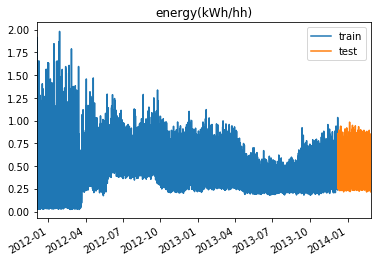

In [7]:
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Dataloaders

In [8]:
data_train = SmartMeterDataSet(df_train, num_context, num_extra_target)
data_test = SmartMeterDataSet(df_test, num_context, num_extra_target)

In [9]:
loader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, 
    collate_fn=collate_fns(num_context, num_extra_target, sample=True),
    num_workers=num_workers,
)

loader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=False, 
    collate_fn=collate_fns(num_context, num_extra_target, sample=False)
)

# Run

In [10]:
x, y, _, _ = next(iter(loader_train))
x.shape, y.shape

(torch.Size([32, 20, 17]), torch.Size([32, 20, 1]))

In [11]:
# # [I 2020-02-01 23:14:15,952] Finished trial#58 resulted in value: -1.3353958129882812. Current 
# # best value is -1.586141586303711 with parameters: 
# a = {
#     'attention_dropout': 0.2,
#     'attention_layers': 2,
#     'batch_size': 16,
#     'batchnorm': False,
#     'det_enc_cross_attn_type': 'multihead',
#     'det_enc_self_attn_type': 'ptmultihead',
#     'dropout': 0,
#     'grad_clip': 40,
#     'hidden_dim': 64,
#     'latent_dim': 64,
#     'latent_enc_self_attn_type': 'multihead',
#     'learning_rate': 0.001922598180719319,
#     'max_nb_epochs': 2,
#     'min_std': 0.005,
#     'n_decoder_layers': 2,
#     'n_det_encoder_layers': 8,
#     'n_latent_encoder_layers': 1,
#     'num_context': 48,
#     'num_extra_target': 24,
#     'num_heads': 8,
#     'num_workers': 4,
#     'use_deterministic_path': False,
#     'use_lvar': True,
#     'use_self_attn': True,
#     'vis_i': 670,
#     'x_dim': 16,
#     'y_dim': 1
# }

In [12]:
from src.models.model import LatentModel
model = LatentModel(
    x_dim=x.shape[-1], 
    y_dim=y.shape[-1], 
    hidden_dim=64*3,
    latent_dim=64*3,
#     dropout=0.,
    min_std=0.01,
#     attention_dropout=0.2,
    num_heads=8,
    n_latent_encoder_layers=2,
    n_det_encoder_layers=4,
    n_decoder_layers=3,
    attention_layers=2,
    latent_enc_self_attn_type="multihead", 
    det_enc_self_attn_type="multihead",
    det_enc_cross_attn_type="multihead",
    use_self_attn=True,
    batchnorm=False,
    use_lvar=False,
    use_deterministic_path=False
).to(device)

optim = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=4)

In [13]:
from torchsummaryX import summary
data = next(iter(loader_train))
data = [d.to(device) for d in data]
context_x, context_y, target_x, target_y = data
with torch.no_grad():
    model.eval()
    summary(model, context_x, context_y, target_x, target_y)
    dist, log_p, kl, loss_mse, loss = model(context_x, context_y, target_x, target_y)

                                                   Kernel Shape  \
Layer                                                             
0__latent_encoder.Linear__input_layer                 [18, 192]   
1__latent_encoder._encoder.0.Linear_linear           [192, 192]   
2__latent_encoder._encoder.0.ReLU_act                         -   
3__latent_encoder._encoder.0.Dropout2d_dropout                -   
4__latent_encoder._encoder.1.Linear_linear           [192, 192]   
5__latent_encoder._encoder.1.ReLU_act                         -   
6__latent_encoder._encoder.1.Dropout2d_dropout                -   
7__latent_encoder._self_attention._W_k.0.Linear...   [192, 192]   
8__latent_encoder._self_attention._W_v.0.Linear...   [192, 192]   
9__latent_encoder._self_attention._W_q.0.Linear...   [192, 192]   
10__latent_encoder._self_attention._W_k.1.Linea...   [192, 192]   
11__latent_encoder._self_attention._W_v.1.Linea...   [192, 192]   
12__latent_encoder._self_attention._W_q.1.Linea...   [192, 192

tensor(0.8428, device='cuda:0')

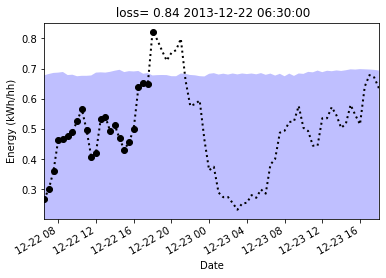

In [14]:
# Lets choose a challenging time to forecast
vis_i = 670 # 290 # 1600
plot_from_loader(loader_test, model, i=vis_i)

0, i=0, loss: 0.8208, test: 0.8269, grad_norm:  1.2, std:  0.69
0, i=100, loss: -0.1645, test: -0.4608, grad_norm:  1.2, std:  0.2
0, i=200, loss: -0.3903, test: -0.4026, grad_norm:  11, std:  0.19
0, i=300, loss: -0.4243, test: -0.74, grad_norm:  8.2, std:  0.16
0, i=400, loss: -0.5319, test: -0.851, grad_norm:  9.9, std:  0.17
0, i=500, loss: -0.7687, test: -1.077, grad_norm:  6.9, std:  0.13
0, i=600, loss: -0.7023, test: -1.02, grad_norm:  16, std:  0.14
0, i=700, loss: -0.941, test: -1.117, grad_norm:  3.8, std:  0.13
0, i=800, loss: -0.8396, test: -1.069, grad_norm:  19, std:  0.12
0, i=900, loss: -0.86, test: -1.137, grad_norm:  13, std:  0.11
0, i=1000, loss: -0.661, test: -1.299, grad_norm:  16, std:  0.12
0, i=1100, loss: -0.7562, test: -1.107, grad_norm:  14, std:  0.11



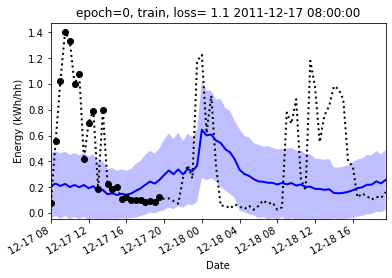

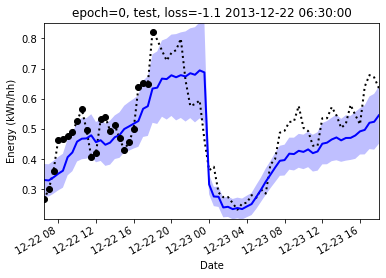

epoch: 0, loss: -0.7562, loss_test:-1.107, kl=0.00033, grad_norm:  14


1, i=0, loss: -1.082, test: -1.196, grad_norm:  30, std:  0.085
1, i=100, loss: -1.04, test: -1.36, grad_norm:  6.9, std:  0.12
1, i=200, loss: -1.07, test: -1.44, grad_norm:  24, std:  0.11
1, i=300, loss: -1.057, test: -1.429, grad_norm:  23, std:  0.11
1, i=400, loss: -1.115, test: -1.456, grad_norm:  26, std:  0.089
1, i=500, loss: -0.7747, test: -1.374, grad_norm:  24, std:  0.13
1, i=600, loss: -0.9168, test: -1.375, grad_norm:  46, std:  0.11
1, i=700, loss: -1.168, test: -1.496, grad_norm:  37, std:  0.083
1, i=800, loss: -1.009, test: -1.546, grad_norm:  12, std:  0.12
1, i=900, loss: -1.228, test: -1.263, grad_norm:  17, std:  0.096
1, i=1000, loss: -1.344, test: -1.558, grad_norm:  30, std:  0.077
1, i=1100, loss: -1.331, test: -1.595, grad_norm:  37, std:  0.075



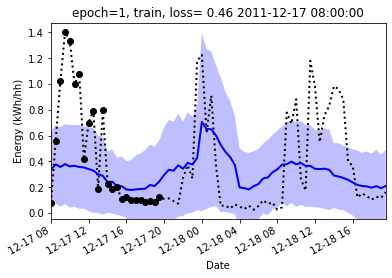

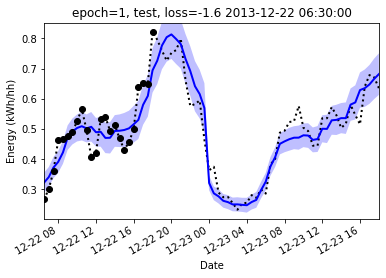

epoch: 1, loss: -1.331, loss_test:-1.595, kl=0.0002, grad_norm:  37


2, i=0, loss: -1.11, test: -1.606, grad_norm:  28, std:  0.11
2, i=100, loss: -1.023, test: -1.528, grad_norm:  20, std:  0.12
2, i=200, loss: -1.105, test: -1.426, grad_norm:  21, std:  0.093
2, i=300, loss: -1.056, test: -1.598, grad_norm:  7.6, std:  0.11
2, i=400, loss: -1.295, test: -1.622, grad_norm:  8, std:  0.093
2, i=500, loss: -1.543, test: -1.675, grad_norm:  20, std:  0.059
2, i=600, loss: -1.377, test: -1.579, grad_norm:  13, std:  0.073
2, i=700, loss: -1.374, test: -1.637, grad_norm:  7.6, std:  0.078
2, i=800, loss: -1.562, test: -1.599, grad_norm:  15, std:  0.065
2, i=900, loss: -1.366, test: -1.634, grad_norm:  15, std:  0.079
2, i=1000, loss: -1.344, test: -1.643, grad_norm:  18, std:  0.097
2, i=1100, loss: -1.347, test: -1.632, grad_norm:  11, std:  0.087



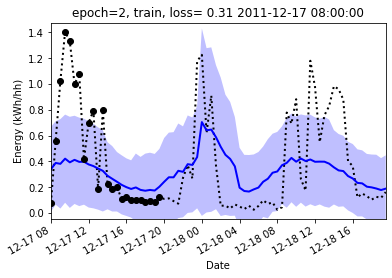

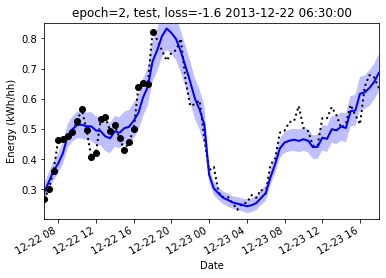

epoch: 2, loss: -1.347, loss_test:-1.632, kl=0.00018, grad_norm:  11


3, i=0, loss: -1.369, test: -1.637, grad_norm:  17, std:  0.075
3, i=100, loss: -1.314, test: -1.647, grad_norm:  15, std:  0.088
3, i=200, loss: -1.249, test: -1.651, grad_norm:  20, std:  0.098
3, i=300, loss: -1.441, test: -1.652, grad_norm:  8.8, std:  0.071
3, i=400, loss: -1.276, test: -1.651, grad_norm:  18, std:  0.079


KeyboardInterrupt: 

In [15]:
epochs = 10
grad_clip = 40
history = []
for epoch in tqdm(range(epochs), unit='epoch'):

    pbar = tqdm(loader_train, unit='batch')
    for i, data in enumerate(pbar):
        model.train()
        assert all(torch.isfinite(d).all() for d in data)
        data = [d.to(device) for d in data]
        context_x, context_y, target_x, target_y = data

        optim.zero_grad()
        y_pred, kl, loss, loss_mse, y_std = model(context_x, context_y, target_x, target_y)

        # These attentive NP models work great when you need uncertainty, but still seem a bit unstable. 
        # Sometimes they produce nans, especically if the data is not fully normalized. 
        assert torch.isfinite(y_pred.sum())
        if not torch.isfinite(loss):
            logger.error("loss is not finite")
            continue
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        if not np.isfinite(grad_norm):
            logger.error("grad_norm is not finite")
            continue
        optim.step()

        if i%100==0:
            model.eval()
            test_loss = plot_from_loader(loader_test, model, i=vis_i, plot=False)
            pbar.set_description(f"{epoch}, loss: {loss.item():4.4g}, test: {test_loss.item():4.4g}")
            print(f"{epoch}, i={i}, loss: {loss.item():4.4g}, test: {test_loss.item():4.4g}, grad_norm: {grad_norm: 2.2g}, std: {y_std.mean().item(): 2.2g}")
            
            history.append(dict(
                n=epoch*len(loader_train) + i,
                epoch=epoch,
                i=i,
                loss=loss.item(),
                kl=kl.mean().item(),
                test_loss=test_loss.item(),
                y_std=y_std.mean().item(),
                grad_norm=grad_norm,
            ))
            scheduler.step(loss.item())
        
    test_loss = plot_from_loader(loader_train, model, i=vis_i, title=f'epoch={epoch}, train,')
    plt.show()
    model.eval()
    test_loss = plot_from_loader(loader_test, model, i=vis_i, title=f'epoch={epoch}, test,')
    plt.show()
    print(f"epoch: {epoch}, loss: {loss.item():4.4g}, loss_test:{test_loss.item():4.4g}, kl={kl.mean().item():2.2g}, grad_norm: {grad_norm: 2.2g}")

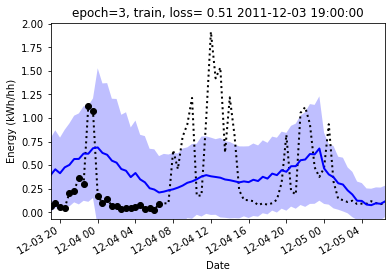

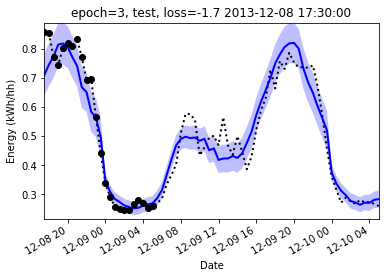

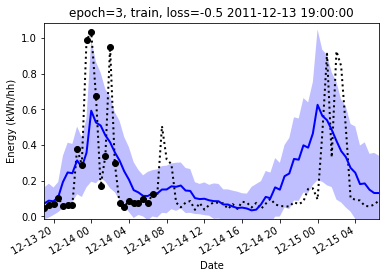

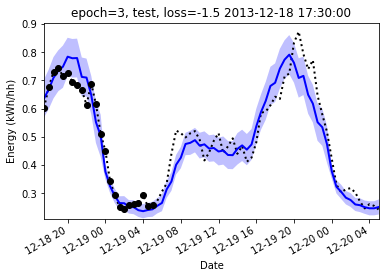

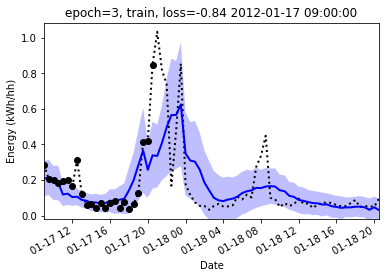

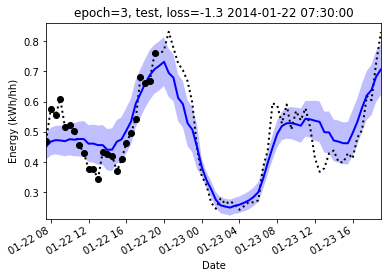

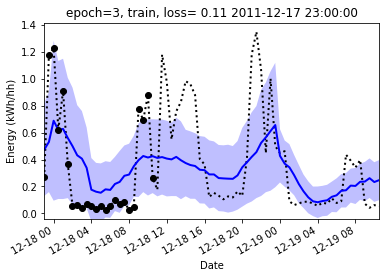

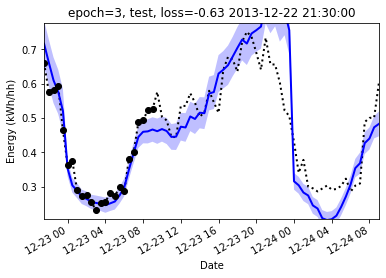

In [20]:
for vis_i in [20, 500, 2160, 700]:
    test_loss = plot_from_loader(loader_train, model, i=vis_i, title=f'epoch={epoch}, train,')
    plt.show()
    model.eval()
    test_loss = plot_from_loader(loader_test, model, i=vis_i, title=f'epoch={epoch}, test,')
    plt.show()

## History

In [ ]:
df_hist = pd.DataFrame(history)
df_hist['n'] = df_hist['n']/(df_hist['epoch']+1)
df_hist.head(3)

In [ ]:
(df_hist[['loss', 'test_loss']]).plot(ylim=[-2,0])

In [ ]:
df_hist[['y_std']].plot(ylim=[0,1e4], logy=True)